In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from pycaret.classification import *
from lightgbm import LGBMClassifier
import joblib

In [2]:
# def fProcesamiento(df):
#     df = df.copy()
#     df["rainperiod"] = df["day"].apply(lambda x: 1 if (x >= 85 and x <= 140) else 0)
#     df["cloud75"] = df["cloud"].apply(lambda x: 1 if x >= 75 else 0)
    
#     df["cloud_humidity"] = df["cloud"] + df["humidity"]
#     df["cloud_sun"] = df["cloud"] + df["sunshine"]
#     df["cloud_humidity_sun"] = df["cloud"] + df["humidity"] + df["sunshine"]
#     df["cloud_windspeed"] = df["cloud"] + df["windspeed"]
#     df["cloud_temperature"] = df["cloud"] + df["temparature"]

#     df["day_sen"] = np.sin(2 * np.pi * df["day"]/365)
#     df["day_cos"] = np.cos(2 * np.pi * df["day"]/365)

#     df["humidity_dewpoint"] = df["humidity"] + df["dewpoint"]
#     df["humidity_mintemp"] = df["humidity"] + df["mintemp"]
#     df["dewpoint_mintemp"] = df["dewpoint"] + df["mintemp"]

#     # Eliminar columnas innecesarias
#     x = df.drop(columns=["id", "maxtemp", "mintemp", "winddirection"])
    
#     # Validar que todas las columnas tengan la misma cantidad de filas
#     for col in x.columns:
#         if len(x[col]) != len(x):
#             raise ValueError(f"La columna '{col}' tiene longitud inconsistente")
    
#     return x

In [3]:
df = pd.read_csv("train.csv")

df = df.drop(columns=["id"])



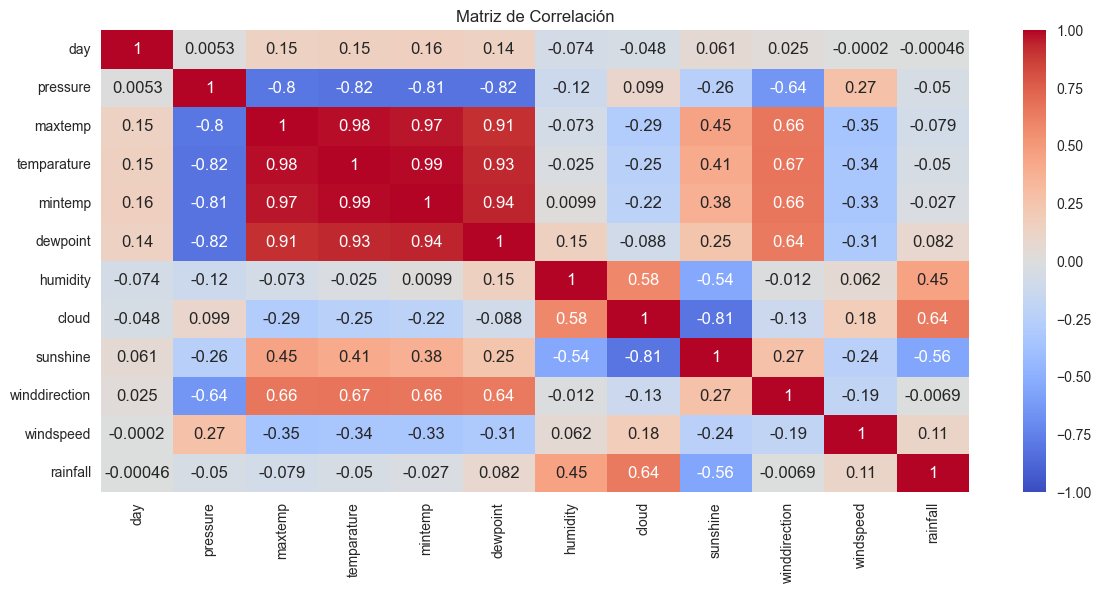

In [4]:
matriz_correlacion = df.corr()

plt.figure(figsize=(14, 6))
sns.heatmap(matriz_correlacion, 
            annot=True,  # Muestra los valores en cada celda
            cmap='coolwarm',  # Mapa de colores
            vmin=-1, vmax=1)  # Rango de valores
plt.title('Matriz de Correlación')
plt.show()

In [5]:
X = df.drop(columns="rainfall")
y = df["rainfall"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [8]:
# df = fProcesamiento(pd.read_csv("train.csv"))


# Iniciar el experimento
exp_clf = setup(
    data=X,
    target=y, 
    session_id=42, 
    train_size=0.8,
    verbose=False
)

In [9]:
best_model = compare_models(n_select=1, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8653,0.8958,0.9348,0.8922,0.9127,0.6180,0.6240,0.0070
lr,Logistic Regression,0.8636,0.8953,0.9379,0.8880,0.9120,0.6092,0.6157,0.5300
rf,Random Forest Classifier,0.8619,0.8809,0.9288,0.8927,0.9101,0.6117,0.6161,0.0510
ridge,Ridge Classifier,0.8613,0.8958,0.9379,0.8854,0.9106,0.6017,0.6090,0.0060
gbc,Gradient Boosting Classifier,0.8590,0.8860,0.9280,0.8900,0.9084,0.6027,0.6070,0.0510
et,Extra Trees Classifier,0.8573,0.8764,0.9311,0.8862,0.9077,0.5936,0.6002,0.0410
xgboost,Extreme Gradient Boosting,0.8573,0.8710,0.9273,0.8886,0.9073,0.5976,0.6020,0.1330
lightgbm,Light Gradient Boosting Machine,0.8539,0.8734,0.9258,0.8859,0.9052,0.5870,0.5913,0.0600
ada,Ada Boost Classifier,0.8533,0.8785,0.9265,0.8847,0.9049,0.5845,0.5888,0.0280
nb,Naive Bayes,0.8499,0.8795,0.8841,0.9144,0.8987,0.6085,0.6109,0.0070


In [56]:
columnas_tras_preprocesamiento = pipeline.named_steps['preprocessor'].get_feature_names_out()

print("Columnas tras preprocesamiento:", list(columnas_tras_preprocesamiento))


Columnas tras preprocesamiento: ['num__day', 'num__pressure', 'num__maxtemp', 'num__temparature', 'num__mintemp', 'num__dewpoint', 'num__humidity', 'num__cloud', 'num__sunshine', 'num__winddirection', 'num__windspeed']


In [57]:
from sklearn.metrics import roc_auc_score
print("El accuracy es:", accuracy_score(y_test, y_pred))
print("El roc auc es:", roc_auc_score(y_test, y_proba))
report=classification_report(y_test, y_pred)
print(report)

El accuracy es: 0.8759124087591241
El roc auc es: 0.8795264998654829
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       135
           1       0.88      0.96      0.92       413

    accuracy                           0.88       548
   macro avg       0.86      0.79      0.81       548
weighted avg       0.87      0.88      0.87       548



In [7]:
import optuna
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def objective(trial):
    # Hiperparámetros para XGBoost
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    # Hiperparámetros para LightGBM
    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 50, 300),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 200),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('lgbm_max_depth', 3, 12),
        'random_state': 42
    }

    # Hiperparámetros para RandomForest
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
        'random_state': 42
    }

    # Meta-modelo
    meta_model = LogisticRegression(
        C=trial.suggest_float('lr_C', 0.1, 10)
    )

    # Modelos base del stacking
    xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
    lgbm_clf = LGBMClassifier(**lgbm_params)
    rf_clf = RandomForestClassifier(**rf_params)

    # Crear stacking
    stacking_clf = StackingClassifier(
        estimators=[
            ('xgb', xgb_clf),
            ('lgbm', lgbm_clf),
            ('rf', rf_clf)
        ],
        final_estimator=meta_model,
        n_jobs=-1
    )

    # Pipeline con escalado opcional
    pipeline_optuna = Pipeline([
        ('scaler', StandardScaler()),  # Puedes quitarlo si ya está escalado
        ('stacking', stacking_clf)
    ])

    # Validación cruzada
    score = cross_val_score(pipeline_optuna, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    
    return -score  # Optuna minimiza, queremos maximizar accuracy

In [8]:
# Iniciar estudio
study = optuna.create_study(direction='minimize')

# Ejecutar optimización
study.optimize(objective, n_trials=50)  # Cambia según tus recursos


print("Mejores parámetros:", study.best_params)
print("Mejor score (Accuracy):", -study.best_value)

[I 2025-05-08 14:23:54,710] A new study created in memory with name: no-name-563606cd-cd0f-4de1-9825-c09548451856
[I 2025-05-08 14:24:00,682] Trial 0 finished with value: -0.8660265905158417 and parameters: {'xgb_n_estimators': 174, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.04601195883539361, 'xgb_subsample': 0.9551323097294837, 'xgb_colsample_bytree': 0.7692484643326989, 'lgbm_n_estimators': 248, 'lgbm_num_leaves': 68, 'lgbm_learning_rate': 0.20299232089354402, 'lgbm_max_depth': 11, 'rf_n_estimators': 68, 'rf_max_depth': 8, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 8, 'lr_C': 7.336702543154761}. Best is trial 0 with value: -0.8660265905158417.
[I 2025-05-08 14:24:06,345] Trial 1 finished with value: -0.864806709457025 and parameters: {'xgb_n_estimators': 239, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.1739057356769635, 'xgb_subsample': 0.8287630031081517, 'xgb_colsample_bytree': 0.6348719236614323, 'lgbm_n_estimators': 297, 'lgbm_num_leaves': 172, 'lgbm_learning_rate': 0.279

Mejores parámetros: {'xgb_n_estimators': 75, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.16637684352071086, 'xgb_subsample': 0.6679705259877615, 'xgb_colsample_bytree': 0.9719473696250619, 'lgbm_n_estimators': 160, 'lgbm_num_leaves': 116, 'lgbm_learning_rate': 0.1164403762770993, 'lgbm_max_depth': 3, 'rf_n_estimators': 295, 'rf_max_depth': 6, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 7, 'lr_C': 6.749698560854031}
Mejor score (Accuracy): 0.8702889461206226


In [9]:

print("Best trial:")
trial = study.best_trial
print(f"  Value: {-trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.8703
  Params: 
    xgb_n_estimators: 75
    xgb_max_depth: 7
    xgb_learning_rate: 0.16637684352071086
    xgb_subsample: 0.6679705259877615
    xgb_colsample_bytree: 0.9719473696250619
    lgbm_n_estimators: 160
    lgbm_num_leaves: 116
    lgbm_learning_rate: 0.1164403762770993
    lgbm_max_depth: 3
    rf_n_estimators: 295
    rf_max_depth: 6
    rf_min_samples_split: 4
    rf_min_samples_leaf: 7
    lr_C: 6.749698560854031


In [12]:
best_trial = study.best_trial
best_params = best_trial.params

# Construir modelos con los mejores parámetros
xgb_best = XGBClassifier(
    n_estimators=best_params['xgb_n_estimators'],
    max_depth=best_params['xgb_max_depth'],
    learning_rate=best_params['xgb_learning_rate'],
    subsample=best_params['xgb_subsample'],
    colsample_bytree=best_params['xgb_colsample_bytree'],
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

lgbm_best = LGBMClassifier(
    n_estimators=best_params['lgbm_n_estimators'],
    num_leaves=best_params['lgbm_num_leaves'],
    learning_rate=best_params['lgbm_learning_rate'],
    max_depth=best_params['lgbm_max_depth'],
    random_state=42
)

rf_best = RandomForestClassifier(
    n_estimators=best_params['rf_n_estimators'],
    max_depth=best_params['rf_max_depth'],
    min_samples_split=best_params['rf_min_samples_split'],
    min_samples_leaf=best_params['rf_min_samples_leaf'],
    random_state=42
)

# Meta-modelo
meta_best = LogisticRegression(C=best_params['lr_C'])

# StackingClassifier final
stacking_final = StackingClassifier(
    estimators=[('xgb', xgb_best), ('lgbm', lgbm_best), ('rf', rf_best)],
    final_estimator=meta_best,
    n_jobs=-1
)

# Pipeline final
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stacking', stacking_final)
])

# Entrenamiento final
final_pipeline.fit(X_train, y_train)

# Guardar modelo para producción
joblib.dump(final_pipeline, "stacking_rain_final.pkl")

['stacking_rain_final.pkl']

In [13]:
X_train.columns


Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')

In [24]:
# Predicción
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

print("Predicción:", y_pred[:5])
print("Probabilidad:", y_proba[:5])

Predicción: [1 1 1 0 1]
Probabilidad: [0.94596567 0.84783644 0.90356711 0.24122294 0.93456061]


In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

Accuracy: 0.8741
ROC AUC: 0.8827


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

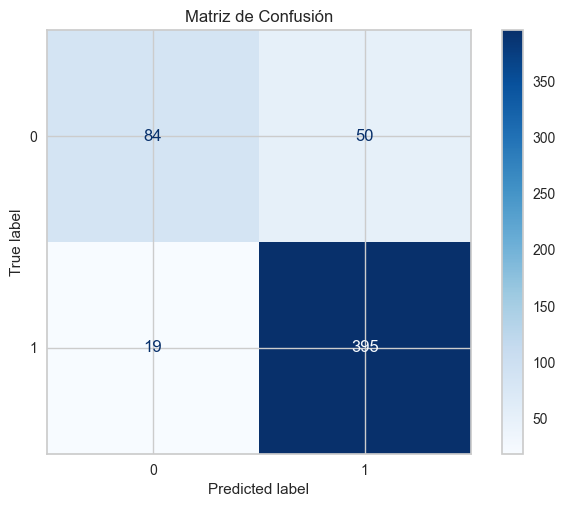

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [22]:
modelo = joblib.load('stacking_rain_final.pkl')

In [23]:
modelo

Pipeline(steps=[('scaler', StandardScaler()),
                ('stacking',
                 StackingClassifier(estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=0.9719473696250619,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric='logloss',
                                                               feature_types=None,
                                                               feature_weig...
                                                               n_estimators=75,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(learning_rate=0.1164403762770993,
                                                                max_depth=3,
                                                                n_estimators=160,
                                                                num_leaves=116,
                                                                random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(max_depth=6,
                                                                        min_samples_leaf=7,
                                                                        min_samples_split=4,
                                                                        n_estimators=295,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(C=6.749698560854031),
                                    n_jobs=-1))])